In [1]:
import matplotlib.pyplot as plt


from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.models import predict
import pandas as pd
import numpy as np

import statistics
from scipy.ndimage import gaussian_filter1d
import math

In [43]:
def load_dataset(name):
    triple_data = open(name).read().strip()
    data = np.array([triple.split(' ')[:-1] for triple in triple_data.split('\n')])  # removing ' .'
    triple = []
    for t in data:
        t[2] = ' '.join(t[2:])
        t = t[:3]
        triple.append(t)
    triple = np.array(triple)
    tf_data = TriplesFactory.from_labeled_triples(triples=triple)
    return tf_data, triple


def create_model(tf_training, tf_testing, embedding, n_epoch, path):
    results = pipeline(
        training=tf_training,
        testing=tf_testing,
        model=embedding,  # 'TransE',  #'RotatE'
        # Training configuration
        training_kwargs=dict(
            num_epochs=n_epoch,
            use_tqdm_batch=False,
        ),
        # Runtime configuration
        random_seed=1235,
        device='cpu',
        
        #training_loop='LCWA',
        
        training_loop='sLCWA',
        negative_sampler='basic', #'bernoulli', 'basic',
        
        #negative_sampler_kwargs=dict(
        #filtered=True,
        #filterer='bloom',
        #filterer_kwargs=dict(
        #    error_rate=0.0001,
        #)),
    )
    model = results.model
    results.save_to_directory(path + embedding)
    return model, results


def filter_prediction(predicted_heads_df, constraint):
    predicted_heads_df = predicted_heads_df[predicted_heads_df.head_label.str.contains(constraint)]
    predicted_heads_df = reset_index(predicted_heads_df)
    return predicted_heads_df


def filter_by_type(predicted_heads, triple_data, entity_type):
    list_entity = predicted_heads.head_label
    entity = []
    for s in list_entity:
        for triple in triple_data:
            b = [s, '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>', entity_type] == triple
            if np.all(b):
                entity.append(s)
                break
    predicted_heads = predicted_heads.loc[predicted_heads.head_label.isin(entity)]
    predicted_heads = reset_index(predicted_heads)
    return predicted_heads, entity


def get_threshold(predicted_heads, percentile):
    score_values = predicted_heads.score.values
    threshold = np.percentile(score_values, percentile)
    threshold_index = predicted_heads.loc[predicted_heads.score > threshold].shape[0]
    print(threshold, threshold_index)
    return threshold, threshold_index


def get_inflection_point(score_values):
    # standard deviation
    stdev = statistics.stdev(score_values)
    # smooth
    smooth = gaussian_filter1d(score_values, stdev)
    # compute second derivative
    smooth_d2 = np.gradient(np.gradient(smooth))
    # find switching points
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]
    if len(infls) == 1:
        return infls[0]
    if len(infls) == 0:
        return len(score_values)
    # middle inflection point
    m_infls = infls[math.ceil(len(infls) / 2)]
    return m_infls


def get_precision(predicted_heads, inflection_index):
    tp_fp = predicted_heads.iloc[0:inflection_index + 1]
    tp = tp_fp.loc[tp_fp.in_training == True].shape[0]
    prec = tp / tp_fp.shape[0]
    return prec, tp


def get_recall(predicted_heads, tp):
    tp_fn = predicted_heads.loc[predicted_heads.in_training == True].shape[0]
    rec = tp / tp_fn
    return rec


def get_f_measure(precision, recall):
    f_measure = 2 * (precision * recall) / (precision + recall)
    return f_measure


def reset_index(predicted_heads):
    predicted_heads.reset_index(inplace=True)
    predicted_heads.drop(columns=['index'], inplace=True)
    return predicted_heads


def compute_metrics(predicted_heads, cut_index):
    precision, tp = get_precision(predicted_heads, cut_index)
    recall = get_recall(predicted_heads, tp)
    f_measure = get_f_measure(precision, recall)
    return pd.DataFrame(columns=['precision', 'recall', 'f_measure'],
                        data=[[precision,recall,f_measure]], index=['MuRe'])

In [3]:
import pykeen
pykeen.models.TransR.hpo_default

{'embedding_dim': {'type': int, 'low': 16, 'high': 256, 'q': 16},
 'relation_dim': {'type': int, 'low': 16, 'high': 256, 'q': 16},
 'scoring_fct_norm': {'type': int, 'low': 1, 'high': 2}}

#### Load dataset I4.0 KG

In [4]:
tf_data, triple_data = load_dataset('sto-enriched-relatedTo.nt')
print('The first two triples:\n', triple_data[:2])
tf_data

/tmp/ipykernel_1401/2716289181.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([triple.split(' ')[:-1] for triple in triple_data.split('\n')])  # removing ' .'


The first two triples:
 [['<http://www.w3.org/1999/02/22-rdf-syntax-ns#value>'
  '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>'
  '<http://www.w3.org/2002/07/owl#AnnotationProperty>']
 ['<http://www.w3.org/2001/XMLSchema#gYear>'
  '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>'
  '<http://www.w3.org/2000/01/rdf-schema#Datatype>']]


TriplesFactory(num_entities=8947, num_relations=107, num_triples=43475, inverse_triples=False)

### Create training and testing set

In [5]:
training, testing = tf_data.split(random_state=1234)

### Buildind the model

In [44]:
model, results = create_model(training, testing, 'MuRe', 10, 'results_I4.0/')

Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/136 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/136 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/136 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/136 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/136 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/136 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/136 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/136 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/136 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/136 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/8.70k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 76.35s seconds


### Evaluating the Results

<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

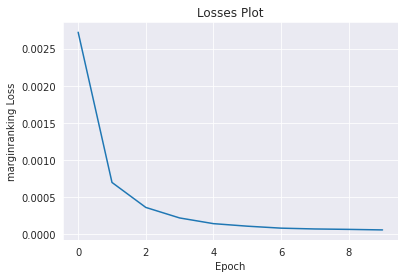

In [19]:
results.plot_losses()

- adjusted mean rank is between [0, 2]. Lower is better.
- mean rank is a positive integer, with a bound based on the number of entities. Lower is better!
- hits@k is reported between [0, 1] and interpreted as a percentage. Higher is better!

In [20]:
results.metric_results.to_df()

,Side,Type,Metric,Value
0,tail,pessimistic,hits_at_1,0.746061
1,tail,pessimistic,hits_at_3,0.789994
2,tail,pessimistic,hits_at_5,0.810466
3,tail,pessimistic,hits_at_10,0.843473
4,tail,pessimistic,arithmetic_mean_rank,27.885336
...,...,...,...,...
136,head,optimistic,inverse_harmonic_mean_rank,0.673147
137,head,optimistic,inverse_median_rank,1.000000
138,head,optimistic,rank_std,211.304080
139,head,optimistic,rank_var,44649.414094


## Link Prediction

The predictions are ordered by their scores.
All interaction functions in PyKEEN have been implemented such that the higher the score (or less negative the score), the more likely a triple is to be true.

### Predict links (Head prediction)

In [21]:
#e1 = '<https://w3id.org/i40/sto#hasClassification>'
#e2 = '<https://w3id.org/i40/rami#Safety>'
e1 = '<https://w3id.org/i40/sto#relatedTo>'
e2 = '<https://w3id.org/i40/sto#IEC_61850_P7_S3_E1>'
predicted_heads = predict.get_head_prediction_df(model, e1, e2, triples_factory=tf_data)
predicted_heads

,head_id,head_label,score,in_training
7143,7143,<https://w3id.org/i40/sto#ISO_18629>,-0.599778,True
6516,6516,<https://w3id.org/i40/sto#DIN_EN_50159>,-0.607756,True
6996,6996,<https://w3id.org/i40/sto#IEC_61850_P7_S4_E2>,-0.609946,True
7588,7588,<https://w3id.org/i40/sto#VDE_2182>,-0.616576,True
7159,7159,<https://w3id.org/i40/sto#ISO_27000>,-0.629118,True
...,...,...,...,...
1229,1229,"""ICS 19.08""@en",-6.592139,False
4249,4249,<http://dbpedia.org/resource/Collection>,-6.644097,False
8010,8010,<https://www.w3.org/ns/oaRangeSelector>,-6.706669,False
6176,6176,<https://en.wikipedia.org/wiki/IEC_61850>,-6.827825,False


### Filter the prediction by the head 'sto'

In [22]:
predicted_heads = filter_prediction(predicted_heads, '<https://w3id.org/i40/sto#')
predicted_heads

/home/rivas/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,head_id,head_label,score,in_training
0,7143,<https://w3id.org/i40/sto#ISO_18629>,-0.599778,True
1,6516,<https://w3id.org/i40/sto#DIN_EN_50159>,-0.607756,True
2,6996,<https://w3id.org/i40/sto#IEC_61850_P7_S4_E2>,-0.609946,True
3,7588,<https://w3id.org/i40/sto#VDE_2182>,-0.616576,True
4,7159,<https://w3id.org/i40/sto#ISO_27000>,-0.629118,True
...,...,...,...,...
1294,6793,<https://w3id.org/i40/sto#GeospatialQuery>,-5.483294,False
1295,6771,<https://w3id.org/i40/sto#FileSizeIEC_62832>,-5.505732,False
1296,7217,<https://w3id.org/i40/sto#IotaEvolutionInterop...,-5.592186,False
1297,7531,<https://w3id.org/i40/sto#Standard>,-5.736464,False


### Filter by entity type 'Standard'. (it take some minutes)

In [23]:
predicted_heads, entity = filter_by_type(predicted_heads, triple_data, '<https://w3id.org/i40/sto#Standard>')
predicted_heads

/tmp/ipykernel_1401/854752121.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  b = [s, '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>', entity_type] == triple


KeyboardInterrupt: 

### Plot of entities predicted score values

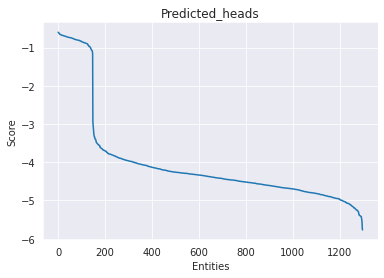

In [24]:
score_values = predicted_heads.score.values
plt.plot(score_values)
plt.xlabel("Entities")
plt.ylabel("Score")
plt.title("Predicted_heads")
plt.show()

### Strategy 'inflection point'

In [25]:
inflection_index = get_inflection_point(predicted_heads.score.values)
compute_metrics(predicted_heads, inflection_index)

,precision,recall,f_measure
MuRe,0.243421,1.0,0.391534


### Strategy 'threshold'

In [26]:
threshold, threshold_index = get_threshold(predicted_heads, 90)
compute_metrics(predicted_heads, threshold_index)

-0.9518002986907954 130


,precision,recall,f_measure
MuRe,1.0,0.885135,0.939068


In [27]:
e1 = '<https://w3id.org/i40/sto#relatedTo>'
e2 = '<https://w3id.org/i40/sto#IEC_61850_P7_S3_E1>'
predicted_heads = predict.get_head_prediction_df(model, e1, e2, triples_factory=testing)
predicted_heads

,head_id,head_label,score,in_training
7143,7143,<https://w3id.org/i40/sto#ISO_18629>,-0.599778,False
6516,6516,<https://w3id.org/i40/sto#DIN_EN_50159>,-0.607756,False
6996,6996,<https://w3id.org/i40/sto#IEC_61850_P7_S4_E2>,-0.609946,False
7588,7588,<https://w3id.org/i40/sto#VDE_2182>,-0.616576,False
7159,7159,<https://w3id.org/i40/sto#ISO_27000>,-0.629118,False
...,...,...,...,...
1229,1229,"""ICS 19.08""@en",-6.592139,False
4249,4249,<http://dbpedia.org/resource/Collection>,-6.644097,False
8010,8010,<https://www.w3.org/ns/oaRangeSelector>,-6.706669,False
6176,6176,<https://en.wikipedia.org/wiki/IEC_61850>,-6.827825,False
